# **House Price Prediction**

In [117]:
import pandas as pd

df = pd.read_csv('HousePricePrediction.csv')

Before we do anything we want to look at the data we have and determine what kind of data each column has. We can see we have some float type values for sqft_living, sqft_lot, sqft_above and sqft_basement, and then we have string types for geographical information and the rest are categorical variables. To evaluate this we need represent all the variables we will use in our model numerically.

In [ ]:
df.head()

We can use the describe function in pandas to look at some of the key features of our data. This can help identify the distribution of our data as well as properties like the min and max value for each variable.

In [ ]:
df.describe()

For any prediction/regression models we need data to be numerical and of the same type. Here we can see we need to deal with non-numeric data types.

In [ ]:
df.dtypes

In [ ]:
df.nunique(axis=0)

To simplify the date field I break this down into month and year. The date, street, zipcode, country and year can all be deleted. The date field I have kept in another format so this can now be deleted. The street name and zipcode are in a very difficult format to work with and each value is too specific to tell us anything meaningful about how price varies with them. The country and year only have one value so this contains no information.

In [118]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

df = df.drop(['date'],axis=1)
df = df.drop(['street'],axis=1)
df = df.drop(['statezip'],axis=1)
df = df.drop(['country'],axis=1)
df = df.drop(['year'],axis=1)

Using the label encoder each city is now automatically represented by a number from 1 to n (where n is the number of cities).

In [119]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['city'] = le.fit_transform(df['city'])

All the remaining columns should now be a numeric data type and so we now convert all the remaining columns to type int64.

In [120]:
for col in df.columns:
    try:
        if df.dtypes[col]!='int64':
            df[col] = df[col].astype('int64')
    except ValueError:
        df.drop([col],axis=1)
        
# df.isnull().sum()

The correlation matrix gives us an initial look at which variables might be a better predictor of price. We can see living room size, amount of room upstairs and number of bathrooms have the highest correlation with price.

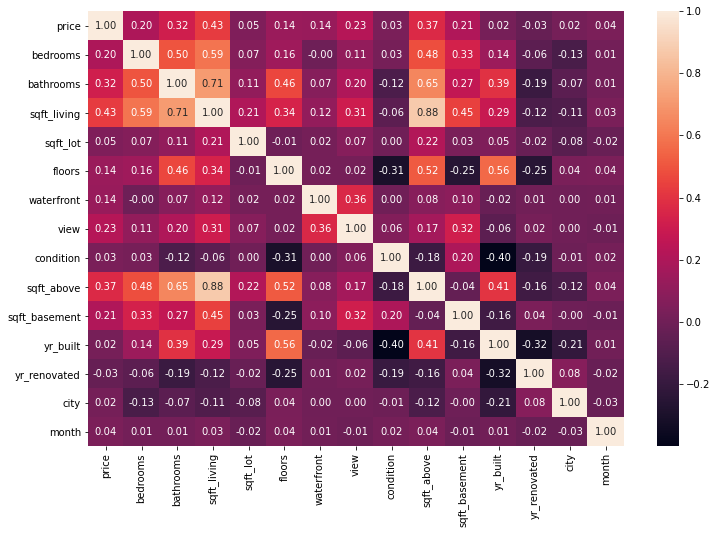

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

We can use the pairplot to visually see how each variable correlates with price. As the correlation matrix showed, the same variables mentioned before seem to have the strongest relationship with price.

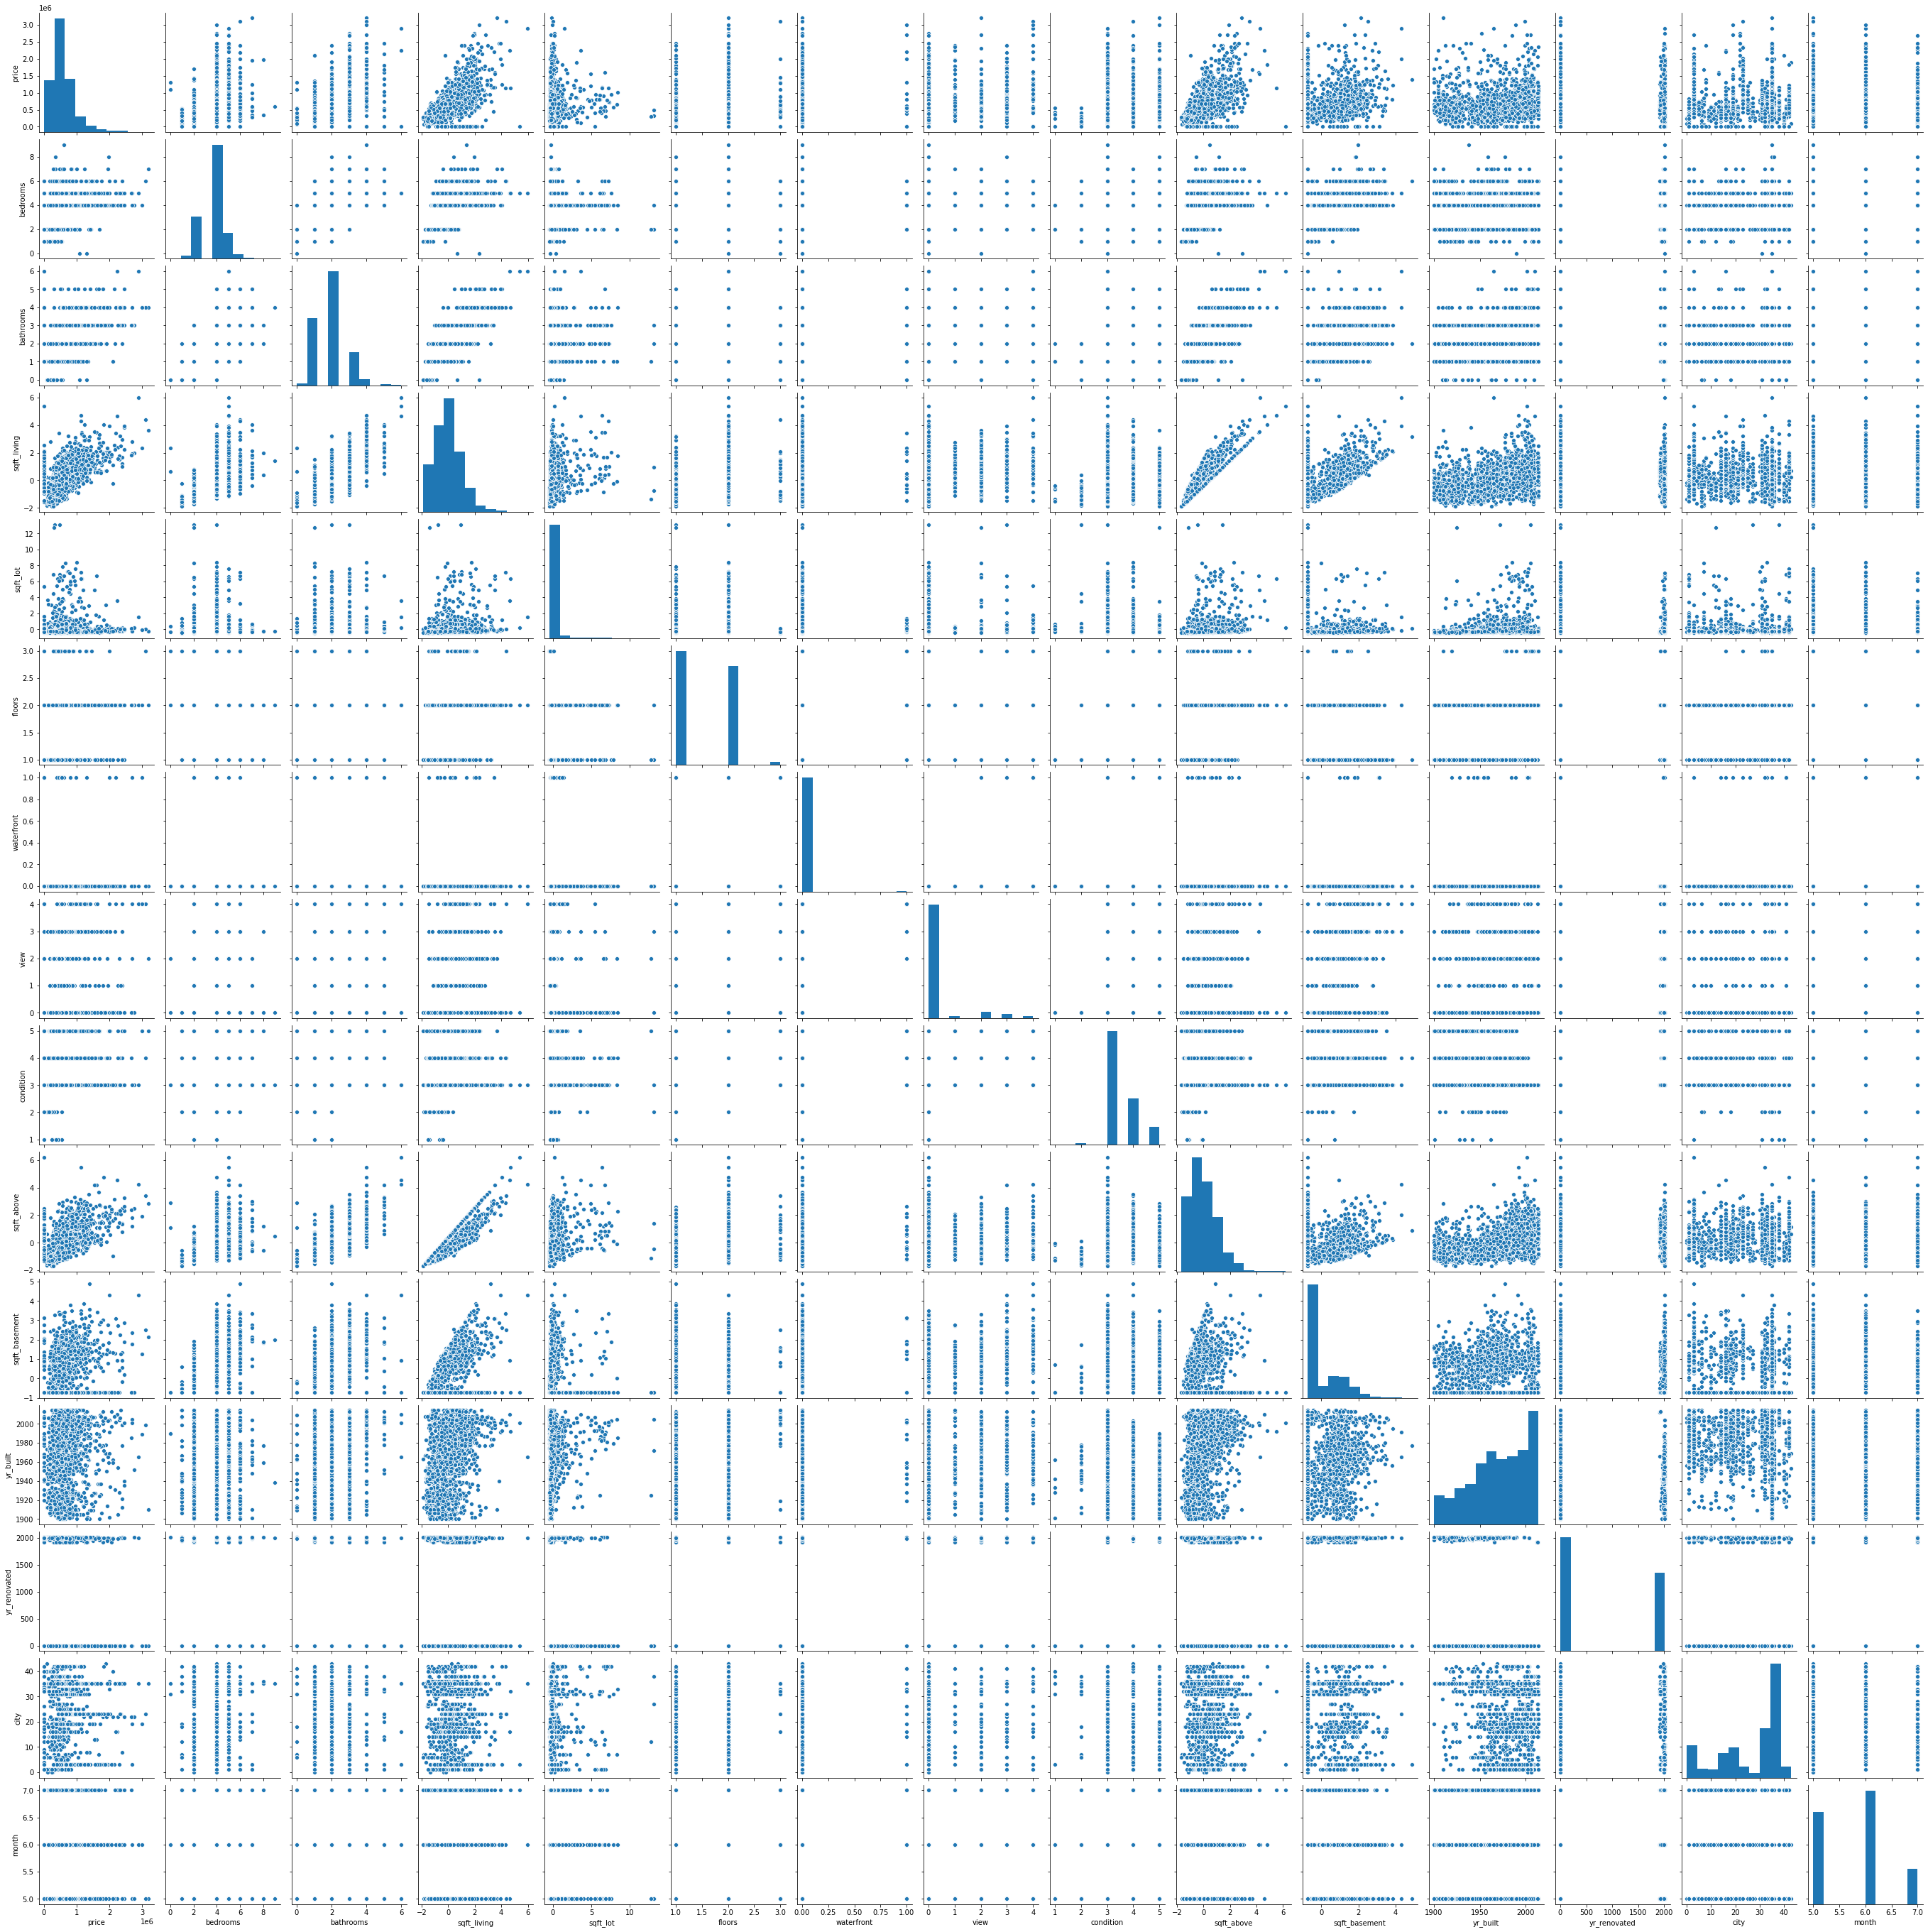

In [129]:
sns.pairplot(df)

We plot each variable against price to get a better look at the relationships but also where there any outliers so we can remove them.

In [ ]:
fig, axes = plt.subplots(len(df.columns.values)-1, 1)

for i, col in enumerate(df.columns.values[:-1]):
    df.plot(x=[col], y=['price'], kind="scatter", ax=axes[i], figsize=(10,60))

plt.show()

Looking at the plots we can determine the outliers and here they are removed.

In [122]:
df.drop(df[(df['bedrooms'] == 3) & (df['price'] > 10000000)].index, inplace=True)
df.drop(df[df['bedrooms'] == 3].index, inplace=True)
df.drop(df[df['price'] > 3500000].index, inplace=True)
df.drop(df[(df['bedrooms'] == 5) & (df['price'] > 6000000)].index, inplace=True)
df.drop(df[(df['sqft_living'] < 2100) & (df['price'] > 2000000)].index, inplace=True)
df.drop(df[df['sqft_lot'] > 600000].index, inplace=True)
df.drop(df[(df['view'] == 0) & (df['price'] > 4000000)].index, inplace=True)
df.drop(df[(df['condition'] == 2) & (df['price'] > 2000000)].index, inplace=True)
df.drop(df[df['sqft_basement'] > 4000].index, inplace=True)

The variables measuring square foot have much bigger values in them than some of the other variables. This is a problem as these might be considered to be more important by the model and receive higher weights even if they aren't as important in predicting price. To counter this we want all the variables to have roughly the same numerical range and so we standardize the variables with comparably large values.

In [123]:
cols = ['sqft_living','sqft_lot','sqft_above','sqft_basement']
for col in cols:
    df[col]=(df[col]-df[col].mean())/df[col].std()

Here we implement a feature selection model on the data which works by the user deciding on a number of features to keep and the model can then either start from nothing and keep adding the variable which has the biggest impact in prediction performance, or start from all variables and work backwards by removing the variable which provides the least impact in prediction performance. This model is evaluated for all number of features to keep and we have run this through a linear regression model and used the Root Mean Square Error (RMSE) to evaluate the performance. The plots show that for either selection method, around 6 variables were optimal to keep.

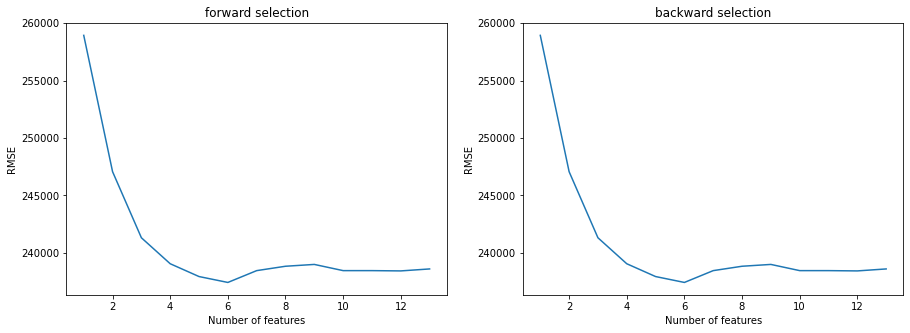

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector

fig, axs = plt.subplots(1, 2, figsize=(15,5))
X = df.drop(['price'],axis=1)
y = df['price']
direction = ['forward', 'backward']
col = 0

for d in direction:
    features = []
    errors = []
    for i in range(1,len(X.columns)):
        sfs = SequentialFeatureSelector(LinearRegression(),n_features_to_select=i, direction=d)
    #     features = sfs.fit(X, y).get_feature_names_out(input_features=None)
        X_ = sfs.fit_transform(X, y)
        y_ = y.to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)

        model = LinearRegression().fit(X_train,y_train)
        y_pred = model.predict(X_test)
        features.append(i)
        errors.append(np.sqrt(mean_squared_error(y_test,y_pred)))

    axs[col].plot(features,errors)
    axs[col].set_title('{} selection'.format(d))
    
    for ax in axs.flat:
        ax.set(xlabel='Number of features', ylabel='RMSE')
    
    col += 1

Using the number of features determined to be optimal from the above plots, I then ran a linear regression using these features as inputs and plotted the prediction prices against the test data. The plots show that the predictions were quite similar to the actual values.

Test price: 308830
Prediction price: 325897.9072526721
Difference: 17067.90725267213


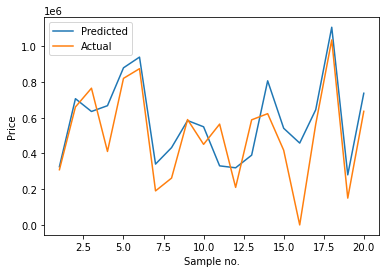

In [127]:
X = df.drop(['price'],axis=1)
y = df['price']
sfs = SequentialFeatureSelector(LinearRegression(),n_features_to_select=6, direction='backward')
X_ = sfs.fit_transform(X, y)
y_ = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)

model = LinearRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Test price:', y_test[0])
print('Prediction price:', y_pred[0])
print('Difference:', abs(y_test[0] - y_pred[0]))

x = [i+1 for i in range(len(np.array(y_pred)))]
plt.plot(x[0:20],y_pred[0:20],label='Predicted')
plt.plot(x[0:20],y_test[0:20], label='Actual')
plt.xlabel("Sample no.")
plt.ylabel("Price")
plt.legend()

We again evaluated the optimal number of features to keep but this time evaluating performace on a KNN algorithm. Here 2 or 3 features looked to be optimal.

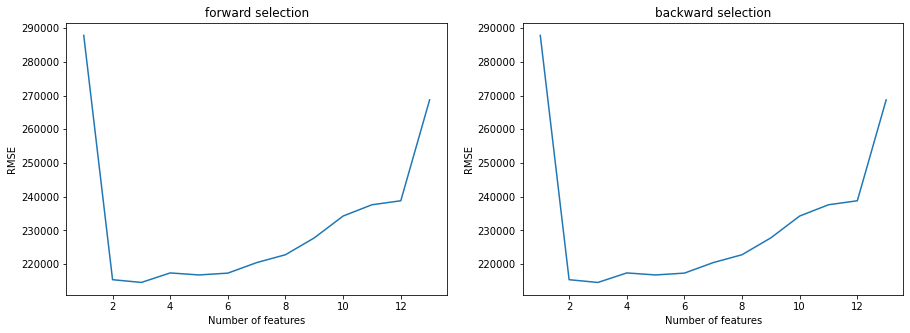

In [126]:
from sklearn.neighbors import KNeighborsRegressor

fig, axs = plt.subplots(1, 2, figsize=(15,5))
X = df.drop(['price'],axis=1)
y = df['price']
knn = KNeighborsRegressor(n_neighbors=5)
direction = ['forward', 'backward']
col = 0

for d in direction:
    features = []
    errors = []
    for i in range(1,len(X.columns)):
        sfs = SequentialFeatureSelector(knn,n_features_to_select=i, direction=d)
        X_ = sfs.fit_transform(X, y)
        y_ = y.to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)

        model = knn.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        features.append(i)
        errors.append(np.sqrt(mean_squared_error(y_test,y_pred)))

    axs[col].plot(features,errors)
    axs[col].set_title('{} selection'.format(d))
    
    for ax in axs.flat:
        ax.set(xlabel='Number of features', ylabel='RMSE')
    
    col += 1

Finally we evaluated the data on 6 features using a random forest regressor, and as we can see the performance was generally slightly worse than that of the previous two algorithms.

Test price: 308830
Prediction price: 288914.17
Difference: 19915.830000000016


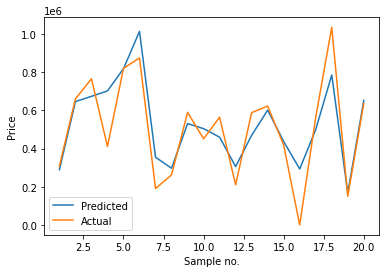

In [128]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(['price'],axis=1)
y = df['price']
sfs = SequentialFeatureSelector(RandomForestRegressor(),n_features_to_select=6, direction='backward')
X_ = sfs.fit_transform(X, y)
y_ = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)

model = RandomForestRegressor().fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Test price:', y_test[0])
print('Prediction price:', y_pred[0])
print('Difference:', abs(y_test[0] - y_pred[0]))

x = [i+1 for i in range(len(np.array(y_pred)))]
plt.plot(x[0:20],y_pred[0:20],label='Predicted')
plt.plot(x[0:20],y_test[0:20], label='Actual')
plt.xlabel("Sample no.")
plt.ylabel("Price")
plt.legend()